# MPMPy Start

In [1]:
# Import packages
import pathlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
# Setup Latex-Matplotlib environment
Latex = False
if Latex:
    print('Setup for Latex')
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        'text.latex.preamble': r"\usepackage{lmodern}",
        "pgf.texsystem": "pdflatex",
        'font.family': 'lmodern',
        'text.usetex': True,
        'pgf.rcfonts': False,
        'font.size': 18.0
    })
    %matplotlib inline
else:
    print('Setup for Notebook')
    matplotlib.use('TkAgg')
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    %matplotlib inline

Setup for Notebook


In [18]:
%run MPMPy/Grid.py
%run MPMPy/Body.py

<Figure size 432x288 with 0 Axes>

In [2]:
from mpm_py import *

Welcome to MPM_Py!


In [3]:
# Set up MPM Space
dt = 0.2
# Grid
X_I = np.array([[0,0],[0.5,0],[1,0],
                [0,0.5],[0.5,0.5],[1.0,0.5],
                [0,1.0],[0.5,1.0],[1.0,1.0]])
Elmt = np.array([[0,1,4,3],[1,2,5,4],
                 [3,4,7,6],[4,5,8,7]
                ],dtype=np.int)
G1 = Grid(X_I, Elmt)
G1.addEBC(0,0,0)
G1.addEBC(0,1,0)


#Particle
B1 = Body()
B1.Emod, B1.nu = 10, 0.25
B1.add_Particle([0.25,0.25], 0.2)
B1.add_Particle([0.75,0.75], 0.1)
B1.v_P[0] = [0.2, 0.2]
B1.v_P[1] = [-0.3, -0.3]

Time = 0

TypeError: 'module' object is not callable

/Users/sash/anaconda3/envs/PY3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


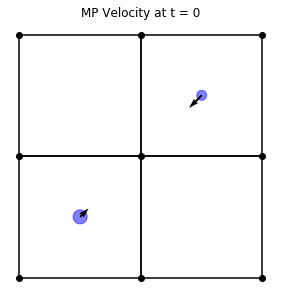

In [21]:
# The Plot Routine
FileName = '/Users/sash/ppower4/mpm_virtual_machining/mpm_vm_502a_sama/InitialState.pgf'
fig = plt.figure('StatePlot')
ax  = plt.gca()
G1.plot(ax, NodeMarks=True)
B1.plot(ax, S=1e3, Velocity=True)
ax.set_aspect('equal')
ax.set_title('MP Velocity at t = '+str(Time))
ax.axis('off')
fig.set_size_inches(w=9.84*0.5,h=9.84*0.5)
if Latex:
    fig.savefig(FileName, dpi=400, bbox_inches='tight')
else:
    fig.show()

In [6]:
G1.reset()

# Build Mapping operator
NIP = np.zeros(G1.NoNodes*B1.NoParticles)
NIP.resize(G1.NoNodes,B1.NoParticles)
dNIP = np.zeros(G1.NoNodes*B1.NoParticles*2)
dNIP.resize(G1.NoNodes,B1.NoParticles,2)
for p in range(B1.NoParticles):
    e,ni,dnidx = G1.SHP(B1.x_P[p])
    NIP[e,p] = ni
    dNIP[e,p] = dnidx.T
#print('Mapping: ')
#print(NIP)

# Map Mass
G1.m_I = np.einsum('IP,P->I',NIP,B1.m_P)
#print('NodalMass: ')
#print(G1.m_I)

# Map Momentum
G1.mv_I = np.einsum('IP,Pi->Ii',NIP, np.einsum('P,Pi->Pi', B1.m_P, B1.v_P))
#print('NodalMomentum: ')
#print(G1.mv_I)

# Map internal Force
G1.f_I -= np.einsum('IPj,Pij->Ii', dNIP, B1.S_P)
#print('GridForces:')
#print(G1.f_I)

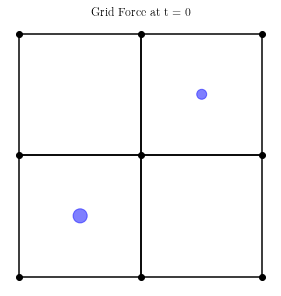

In [8]:
# The Plot Routine
# The Force Plot
FileName = '/Users/sash/ppower4/mpm_virtual_machining/mpm_vm_503a_sama/GridStateF.pgf'
plt.figure('StatePlot').clf()
fig = plt.figure('StatePlot')
ax  = plt.gca()
G1.plot(ax, NodeMarks=True, Force=True)
B1.plot(ax, S=1e3)
ax.set_aspect('equal')
ax.set_title('Grid Force at t = '+str(Time))
ax.axis('off')
fig.set_size_inches(w=9.84*0.5,h=9.84*0.5)
if Latex:
    fig.savefig(FileName, dpi=400, bbox_inches='tight')
else:
    fig.show()

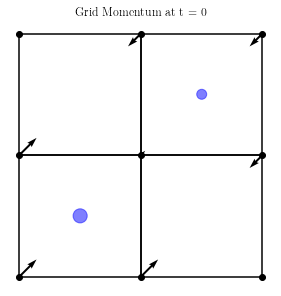

In [9]:
# The Momentum Plot
FileName = '/Users/sash/ppower4/mpm_virtual_machining/mpm_vm_503a_sama/GridStateM.pgf'
plt.figure('StatePlot').clf()
fig = plt.figure('StatePlot')
ax  = plt.gca()
G1.plot(ax, NodeMarks=True, Momentum=True)
B1.plot(ax, S=1e3)
ax.set_aspect('equal')
ax.set_title('Grid Momentum at t = '+str(Time))
ax.axis('off')
fig.set_size_inches(w=9.84*0.5,h=9.84*0.5)
if Latex:
    fig.savefig(FileName, dpi=400, bbox_inches='tight')
else:
    fig.show()

In [10]:
# Solution of the Grid
m_I_inv = np.piecewise(G1.m_I, [G1.m_I > 1e-6, G1.m_I <= 1e-6], [lambda x : 1/x, lambda x : 0])
G1.a_I = np.einsum('ij,i->ij', G1.f_I, m_I_inv)
G1.v_I = np.einsum('ij,i->ij', G1.mv_I, m_I_inv) + G1.a_I * dt
G1.u_I = np.einsum('ij,i->ij', G1.mv_I, m_I_inv) * dt + 0.5 * G1.a_I * dt**2
for NodeNumber, DofIndex, Value in G1.EBC_Container:
    G1.a_I[NodeNumber,DofIndex] = 0
    G1.v_I[NodeNumber,DofIndex] = 0
    G1.u_I[NodeNumber,DofIndex] = 0
Time += 1

/Users/sash/anaconda3/envs/PY3/lib/python3.7/site-packages/matplotlib/quiver.py:696: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/sash/anaconda3/envs/PY3/lib/python3.7/site-packages/matplotlib/quiver.py:696: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/sash/anaconda3/envs/PY3/lib/python3.7/site-packages/matplotlib/quiver.py:748: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/Users/sash/anaconda3/envs/PY3/lib/python3.7/site-packages/matplotlib/quiver.py:762: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength
/Users/sash/anaconda3/envs/PY3/lib/python3.7/site-packages/matplotlib/quiver.py:696: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/sash/anaconda3/envs/PY3/l

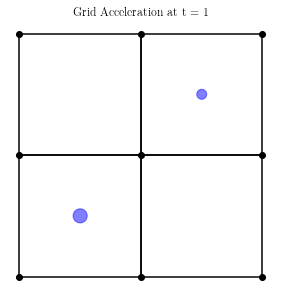

In [11]:
# The Plot Routine
# The Acceleration
FileName = '/Users/sash/ppower4/mpm_virtual_machining/mpm_vm_504a_sama/GridStateA.pgf'
plt.figure('StatePlot').clf()
fig = plt.figure('StatePlot')
ax  = plt.gca()
G1.plot(ax, NodeMarks=True, Acceleration=True, S=1)
B1.plot(ax, S=1e3)
ax.set_aspect('equal')
ax.set_title('Grid Acceleration at t = '+str(Time))
ax.axis('off')
fig.set_size_inches(w=9.84*0.5,h=9.84*0.5)
fig.savefig(FileName, dpi=400, bbox_inches='tight')

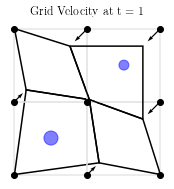

In [12]:
# The Velocity + Disp
FileName = '/Users/sash/ppower4/mpm_virtual_machining/mpm_vm_504a_sama/GridStateV.pgf'
FileName2 = '/Users/sash/ppower4/mpm_virtual_machining/mpm_vm_505a_sama/GridStateVSmall.pgf'
plt.figure('StatePlot').clf()
fig = plt.figure('StatePlot')
ax  = plt.gca()
G1.plot(ax, NodeMarks=True, Velocity=True, DeformedMesh=True, S=2)
B1.plot(ax, S=1e3)
ax.set_aspect('equal')
ax.set_title('Grid Velocity at t = '+str(Time))
ax.axis('off')
fig.set_size_inches(w=9.84*0.5,h=9.84*0.5)
if Latex:
    fig.savefig(FileName, dpi=400, bbox_inches='tight')
    fig.set_size_inches(w=9.84*0.3,h=9.84*0.3)
    fig.savefig(FileName2, dpi=400, bbox_inches='tight')
else:
    fig.show()

In [13]:
# Map Back and advance in time (one pic)
# Map accelerations
B1.a_P = np.einsum('IP,Ii->Pi', NIP, G1.a_I)
#print('Particle Accelerations:')
#print(B1.a_P)

# Map velocities
B1.v_P_bar = np.einsum('IP,Ii->Pi', NIP, G1.v_I)
#print('Particle Velocities:')
#print(B1.v_P)

# Map velocity gradient
B1.L_P = np.einsum('IPj,Ii->Pij', dNIP, G1.v_I)
#print('Particle Velocity Gradient:')
#print(B1.L_P)

# Advance in time
B_old = B1 # saved for post
I = np.eye(2)
B1.x_P = B1.x_P + B1.v_P_bar * dt
B1.v_P = B1.v_P + B1.a_P * dt
B1.F_P = np.einsum('Pik,Pkj->Pij', B1.L_P[:]*dt + I, B1.F_P)
B1.S_P = np.array(list(map(B1.Sig, B1.F_P)))


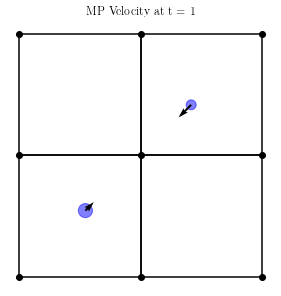

In [14]:
# The Plot Routine
FileName = '/Users/sash/ppower4/mpm_virtual_machining/mpm_vm_506a_sama/State.pgf'
fig = plt.figure('StatePlot')
ax  = plt.gca()
G1.plot(ax, NodeMarks=True)
B1.plot(ax, S=1e3, Velocity=True)
ax.set_aspect('equal')
ax.set_title('MP Velocity at t = '+str(Time))
ax.axis('off')
fig.set_size_inches(w=9.84*0.5,h=9.84*0.5)
if Latex:
    fig.savefig(FileName, dpi=400, bbox_inches='tight')
else:
    fig.show()

In [15]:
print(B1.L_P)

[[[ 0.03333333  0.03333333]
  [ 0.03333333  0.03333333]]

 [[-0.33333333 -0.33333333]
  [-0.33333333 -0.33333333]]]


In [16]:
G1.reset()

# Build Mapping operator
NIP = np.zeros(G1.NoNodes*B1.NoParticles)
NIP.resize(G1.NoNodes,B1.NoParticles)
dNIP = np.zeros(G1.NoNodes*B1.NoParticles*2)
dNIP.resize(G1.NoNodes,B1.NoParticles,2)
for p in range(B1.NoParticles):
    e,ni,dnidx = G1.SHP(B1.x_P[p])
    NIP[e,p] = ni
    dNIP[e,p] = dnidx.T
#print('Mapping: ')
#print(NIP)

# Map Mass
G1.m_I = np.einsum('IP,P->I',NIP,B1.m_P)
#print('NodalMass: ')
#print(G1.m_I)

# Map Momentum
G1.mv_I = np.einsum('IP,Pi->Ii',NIP, np.einsum('P,Pi->Pi', B1.m_P, B1.v_P))
#print('NodalMomentum: ')
#print(G1.mv_I)

# Map internal Force
G1.f_I -= np.einsum('IPj,Pij->Ii', dNIP, B1.S_P)
#print('GridForces:')
#print(G1.f_I)

In [19]:
G1.f_I

array([[ 0.14613333,  0.14613333],
       [-0.03946667,  0.0672    ],
       [ 0.        ,  0.        ],
       [ 0.0672    , -0.03946667],
       [-2.0512    , -2.0512    ],
       [ 0.81066667, -0.256     ],
       [ 0.        ,  0.        ],
       [-0.256     ,  0.81066667],
       [ 1.32266667,  1.32266667]])

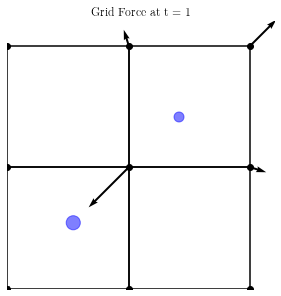

In [24]:
# The Plot Routine
# The Force Plot
FileName = '/Users/sash/ppower4/mpm_virtual_machining/mpm_vm_507a_sama/GridStateF.pgf'
plt.figure('StatePlot').clf()
fig = plt.figure('StatePlot')
ax  = plt.gca()
G1.plot(ax, NodeMarks=True, Forces=True, Scale=0.5)
B1.plot(ax, S=1e3)
ax.set_aspect('equal')
ax.set_title('Grid Force at t = '+str(Time))
ax.axis('off')
ax.set_xlim(0,1.1)
ax.set_ylim(0,1.1)
fig.set_size_inches(w=9.84*0.5,h=9.84*0.5)
if Latex:
    fig.savefig(FileName, dpi=400, bbox_inches='tight')
else:
    fig.show()

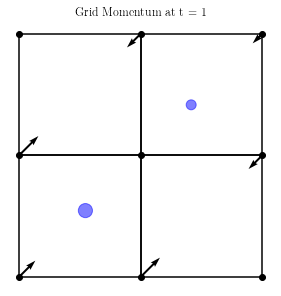

In [18]:
# The Momentum Plot
FileName = '/Users/sash/ppower4/mpm_virtual_machining/mpm_vm_507a_sama/GridStateM.pgf'
plt.figure('StatePlot').clf()
fig = plt.figure('StatePlot')
ax  = plt.gca()
G1.plot(ax, NodeMarks=True, Momentum=True)
B1.plot(ax, S=1e3)
ax.set_aspect('equal')
ax.set_title('Grid Momentum at t = '+str(Time))
ax.axis('off')
fig.set_size_inches(w=9.84*0.5,h=9.84*0.5)
if Latex:
    fig.savefig(FileName, dpi=400, bbox_inches='tight')
else:
    fig.show()

In [42]:
# Solution of the Grid
m_I_inv = np.piecewise(G1.m_I, [G1.m_I > 1e-6, G1.m_I <= 1e-6], [lambda x : 1/x, lambda x : 0])
G1.a_I = np.einsum('ij,i->ij', G1.f_I, m_I_inv)
G1.v_I = np.einsum('ij,i->ij', G1.mv_I, m_I_inv) + G1.a_I * dt
G1.u_I = np.einsum('ij,i->ij', G1.mv_I, m_I_inv) * dt + 0.5 * G1.a_I * dt**2
for NodeNumber, DofIndex, Value in G1.EBC_Container:
    G1.a_I[NodeNumber,DofIndex] = 0
    G1.v_I[NodeNumber,DofIndex] = 0
    G1.u_I[NodeNumber,DofIndex] = 0
Time += 1

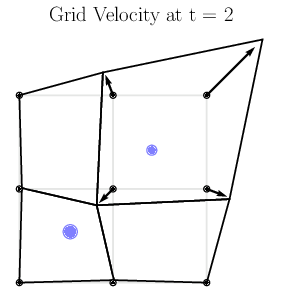

In [51]:
# The Plot Routine
# The Acceleration
FileName = '/Users/sash/ppower4/mpm_virtual_machining/mpm_vm_508a_sama/GridStateA.pgf'
plt.figure('StatePlot').clf()
fig = plt.figure('StatePlot')
ax  = plt.gca()
G1.plot(ax, NodeMarks=True, Acceleration=True, S=.2)
B1.plot(ax, S=1e3)
ax.set_aspect('equal')
ax.set_title('Grid Acceleration at t = '+str(Time))
ax.set_xlim(0,1.4)
ax.set_ylim(0,1.4)
ax.axis('off')
fig.set_size_inches(w=9.84*0.5,h=9.84*0.5)
fig.savefig(FileName, dpi=400, bbox_inches='tight')
# The Velocity + Disp
FileName = '/Users/sash/ppower4/mpm_virtual_machining/mpm_vm_508a_sama/GridStateV.pgf'
plt.figure('StatePlot').clf()
fig = plt.figure('StatePlot')
ax  = plt.gca()
G1.plot(ax, NodeMarks=True, Velocity=True, DeformedMesh=True, S=.2)
B1.plot(ax, S=1e3)
ax.set_aspect('equal')
ax.set_title('Grid Velocity at t = '+str(Time))
ax.axis('off')
fig.set_size_inches(w=9.84*0.5,h=9.84*0.5)
if Latex:
    fig.savefig(FileName, dpi=400, bbox_inches='tight')
else:
    fig.show()

# DEVEL

In [813]:
# A plane strain linear elasticity function
def Sig(F):
    Emod = 10
    nu = 0.3
    lam = (Emod*nu)/((1+nu)*(1-2*nu))
    mue = Emod/(2*(1+nu))
    eps = np.array([[F[0,0]-1,0.5*(F[0,1]+F[1,0]),0],[0.5*(F[0,1]+F[1,0]),F[1,1]-1,0],[0,0,0]])
    sig = lam * (eps[0,0]+eps[1,1]+eps[2,2]) * np.eye(3) + 2 * mue * eps
    return sig[:2,:2]

print( Sig(np.array([[1.1,0.1],[0,1]])) )


[[1.34615385 0.38461538]
 [0.38461538 0.57692308]]


In [491]:
# function to evaluate shape functions
XP = np.array([0.7,0.6])
XI = np.array(G1.X_I[G1.Elmt[3]])
PointInsideQuadQ(XI,XP)
xi, eta = 0.0, 0.0
for iter in range(10):
    NI = (1/4) * np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])
    dNI = (1/4) * np.array([
        [-(1-eta),(1-eta),(1+eta),-(1+eta)],
        [-(1-xi),-(1+xi),(1+xi),(1-xi)]])
    XP_i = NI.dot(XI)
    J = dNI.dot(XI) 
    R = XP_i - XP
    if np.linalg.norm(R) <= 1e-8: break
    delta_Xi = - np.linalg.inv(J).dot(R)
    xi  += delta_Xi[0]
    eta += delta_Xi[1]



In [45]:
# stability cirterion
Emod, nu, rho = 200e9,0.3,7850
l_crit = (6e-2)/60
array_of_velocities = [[1160,1160]]#B1.v_P
# friderich - lewy 
cp = np.sqrt((Emod*(1-nu))/((1+nu)*(1-2*nu)*rho))
print(cp)
dt_crit = l_crit/(max(cp + np.sqrt(np.sum(np.abs(array_of_velocities)**2,axis=-1))))
print(dt_crit)

5856.3566556183205
1.3338945671655225e-07


In [46]:
# stability cirterion
Emod, nu, rho = 117e9,0.35,8930
l_crit = (1e-2)/20
array_of_velocities = [[250,250]]#B1.v_P
# friderich - lewy 
cp = np.sqrt((Emod*(1-nu))/((1+nu)*(1-2*nu)*rho))
print(cp)
dt_crit = l_crit/(max(cp + np.sqrt(np.sum(np.abs(array_of_velocities)**2,axis=-1))))
print(dt_crit)

4585.602105682921
1.0123188070854782e-07
